In [ ]:
#Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import tensorflow as tf
from scipy import stats 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Input,LSTM,Reshape,Conv2D,Conv1D,Flatten,Dropout,BatchNormalization, LeakyReLU, concatenate, GRU, GlobalMaxPooling1D, GlobalMaxPooling2D, Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/P300_Speller_data/first_experiment/800ms_sw'

/content/drive/MyDrive/P300_Speller_data/first_experiment/800ms_sw


In [ ]:
pos_data = scipy.io.loadmat('pos_data_S5_800ms_Spectral_whitened.mat')['pos_data']
print(pos_data.shape)
neg_data = scipy.io.loadmat('neg_data_S5_800ms_Spectral_whitened.mat')['neg_data']  #_Spectral_whitened
print(neg_data.shape)


(200, 8, 150)
(200, 8, 1050)


In [ ]:
pos_stat = scipy.io.loadmat('pos_data_stat_S5_800ms_Spectral_whitened.mat')['pos_stat']
print(pos_stat.shape)
neg_stat = scipy.io.loadmat('neg_data_stat_S5_800ms_Spectral_whitened.mat')['neg_stat']  #_Spectral_whitened
print(neg_stat.shape)

(8, 8, 150)
(8, 8, 1050)


In [ ]:
data = np.append(pos_data ,neg_data ,axis = 2) 
data_stat = np.append(pos_stat ,neg_stat ,axis = 2) 
print(data.shape)
print(data_stat.shape)

(200, 8, 1200)
(8, 8, 1200)


In [ ]:
labels = np.append(np.ones((pos_data.shape[2],)),np.zeros((neg_data.shape[2],)))
print(pos_data.shape[2])
print(neg_data.shape[2])
print(labels.shape)
print(labels)

150
1050
(1200,)
[1. 1. 1. ... 0. 0. 0.]


In [ ]:
data = data
data = np.moveaxis(data,-1,0)
# , timesteps, features/units
#data = np.moveaxis(data,-1,1)
print(data.shape)

data_stat = data_stat
data_stat = np.moveaxis(data_stat,-1,0)
# , timesteps, features/units
#data = np.moveaxis(data,-1,1)
print(data_stat.shape)

(1200, 200, 8)
(1200, 8, 8)


##1DCNN +RNN

In [ ]:
X_train, X_val,X_s_train,X_s_val, y_train, y_val = train_test_split(data, data_stat, labels, test_size=0.2, random_state=42, stratify = labels)
print(X_train.shape)
print(X_s_train.shape)
print(y_train.shape)
print(X_val.shape)
print(X_s_val.shape)
print(y_val.shape)

(960, 200, 8)
(960, 8, 8)
(960,)
(240, 200, 8)
(240, 8, 8)
(240,)


In [ ]:
#undersampling
#import random


#c = 0
#while True:
#    no_data = X_train.shape[0]
#    test_list = [i for i in range(no_data)]
#    random_num = random.choice(test_list) 
#    if y_train[random_num] == 0:
#        
#        #label = np.reshape(label, (1,1))
#        X_train = np.delete(X_train,random_num,axis = 0) 
#        y_train = np.delete(y_train,random_num,axis = 0)
#    if X_train.shape[0] == 480:
#      break
#print(X_train.shape)
#print(y_train.shape)

In [ ]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_val))

Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})


In [ ]:
#Model building
#model best for second experiment
inputX1 = Input(shape = X_train[1,:,:].shape) 
y_pred = Conv1D(filters = 16, kernel_size =10, strides = 5, activation='relu')(inputX1)
print(y_pred.shape)

y_pred =LSTM(units=64,activation='tanh',dropout=0.1,return_sequences=True,)(y_pred)   #dropout = 0.1      units =64
y_pred = Flatten()(y_pred)
y_pred = Dense(16,activation='relu')(y_pred)
y_pred = Dropout(0.3)(y_pred)
y_pred = Dense(1,activation='sigmoid')(y_pred)

(None, 39, 16)


In [ ]:
#Model building
#model with statistical features
inputX1 = Input(shape = X_train[1,:,:].shape) 
inputX2 = Input(shape = X_s_train[1,:,:].shape)

x1 = Conv1D(filters = 16, kernel_size =10, strides = 5, activation='relu')(inputX1)
print(x1.shape)

x1 =LSTM(units=64,activation='tanh',dropout=0.1,return_sequences=True,)(x1)   #dropout = 0.1      units =64
x1 = Flatten()(x1)
x1 = Model(inputs=inputX1, outputs=x1)

x2 = Flatten()(inputX2)
print(x2.shape)
x2 = Dense(32,activation='relu')(x2)
x2 = Model(inputs=inputX2, outputs=x2)

y_pred = concatenate([x1.output, x2.output])
print(y_pred.shape)
y_pred = Dense(16,activation='relu')(y_pred)
y_pred = Dropout(0.3)(y_pred)
y_pred = Dense(1,activation='sigmoid')(y_pred)

(None, 39, 16)
(None, 64)
(None, 2528)


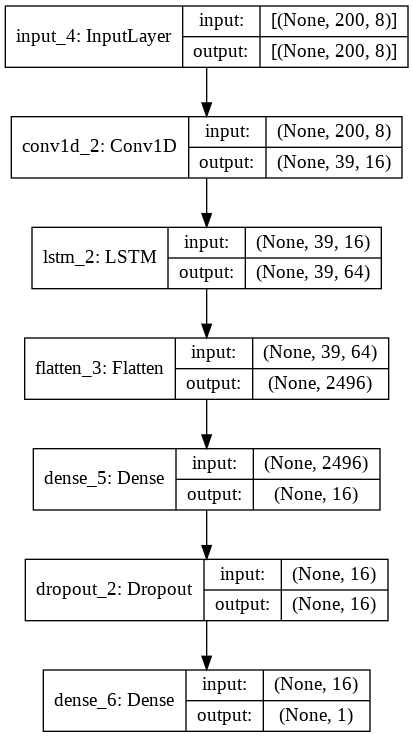

In [ ]:
model = Model(inputs=inputX1, outputs=y_pred)
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
adam = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics = ['accuracy'])
print("Model Training")
history = model.fit(x=[X_train,X_s_train], y=y_train, epochs=100,validation_data=([X_val,X_s_val], y_val),verbose=1)   

Model Training
Epoch 1/100
30/30 [==============================] - 4s 54ms/step - loss: 0.4745 - accuracy: 0.8000 - val_loss: 0.3079 - val_accuracy: 0.8750
Epoch 2/100
30/30 [==============================] - 1s 23ms/step - loss: 0.2744 - accuracy: 0.8814 - val_loss: 0.2395 - val_accuracy: 0.8792
Epoch 3/100
30/30 [==============================] - 1s 23ms/step - loss: 0.2263 - accuracy: 0.9146 - val_loss: 0.1999 - val_accuracy: 0.9250
Epoch 4/100
30/30 [==============================] - 1s 24ms/step - loss: 0.1764 - accuracy: 0.9198 - val_loss: 0.1830 - val_accuracy: 0.9292
Epoch 5/100
30/30 [==============================] - 1s 25ms/step - loss: 0.1222 - accuracy: 0.9469 - val_loss: 0.1538 - val_accuracy: 0.9333
Epoch 6/100
30/30 [==============================] - 1s 23ms/step - loss: 0.1147 - accuracy: 0.9617 - val_loss: 0.1872 - val_accuracy: 0.9083
Epoch 7/100
30/30 [==============================] - 1s 22ms/step - loss: 0.0936 - accuracy: 0.9661 - val_loss: 0.1579 - val_accuracy

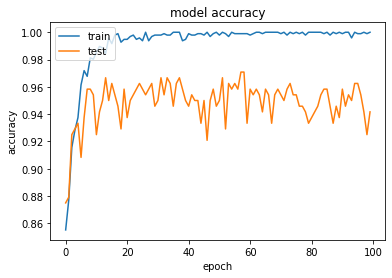

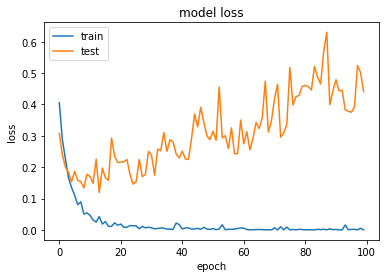

Max Val Accuracy : 0.9708333611488342


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plt.plot(history.history['auc'])
#plt.plot(history.history['val_auc'])
#plt.title('model AUC')
#plt.ylabel('AUC')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()


#plt.plot(history.history['specificity_at_sensitivity'])
#plt.plot(history.history['val_specificity_at_sensitivity'])
#plt.title('model sensitivity')
#plt.ylabel('sensitivity')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()

print("Max Val Accuracy :",max(history.history['val_accuracy']))
#print("Max Val AUC :",max(history.history['val_auc']))
#print("Max Val Sensitivity :",max(history.history['val_specificity_at_sensitivity']))

#5 fold cross validation

In [ ]:
#10 fold cross validation
cross_val=[]
from sklearn.model_selection import KFold, StratifiedKFold
from collections import Counter
skf=StratifiedKFold(n_splits=5,random_state=14, shuffle=True)
i=0
for train_ind , test_ind in  skf.split(data,labels):
  i+=1
  print('5 Fold :' + str(i))
  X_train = data[train_ind ,:,:]
  X_s_train = data_stat[train_ind ,:,:]
  y_train = labels[train_ind]
  
  X_val = data[test_ind,:,:]
  X_s_val = data_stat[test_ind,:,:]
  y_val = labels[test_ind]
  
  print(X_train.shape)
  print(X_s_train.shape)
  print(y_train.shape)
  print(X_val.shape)
  print(X_s_val.shape)
  print(y_val.shape)
  print(Counter(y_train))
  print(Counter(y_val))

  #Model building
  #model with statistical features
  inputX1 = Input(shape = X_train[1,:,:].shape) 
  inputX2 = Input(shape = X_s_train[1,:,:].shape)

  x1 = Conv1D(filters = 16, kernel_size =10, strides = 5, activation='relu')(inputX1)
  print(x1.shape)

  x1 =LSTM(units=64,activation='tanh',dropout=0.1,return_sequences=True,)(x1)   #dropout = 0.1      units =64
  x1 = Flatten()(x1)
  x1 = Model(inputs=inputX1, outputs=x1)

  x2 = Flatten()(inputX2)
  print(x2.shape)
  x2 = Dense(32,activation='relu')(x2)
  x2 = Model(inputs=inputX2, outputs=x2)

  y_pred = concatenate([x1.output, x2.output])
  print(y_pred.shape)
  y_pred = Dense(16,activation='relu')(y_pred)
  y_pred = Dropout(0.3)(y_pred)
  y_pred = Dense(1,activation='sigmoid')(y_pred)

  model = Model(inputs=[inputX1,inputX2], outputs=y_pred)

  adam = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
  model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics = ['accuracy'])
  print("Model Training")
  history = model.fit(x=[X_train,X_s_train], y=y_train, epochs=100,validation_data=([X_val,X_s_val], y_val),verbose=0) 

  max_acc = max(history.history['val_accuracy'])
  print("Max Val Accuracy :", max_acc)

  cross_val.append(max_acc)

  #break

5 Fold :1
(960, 200, 8)
(960, 8, 8)
(960,)
(240, 200, 8)
(240, 8, 8)
(240,)
Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})
(None, 39, 16)
(None, 64)
(None, 2528)
Model Training
Max Val Accuracy : 0.9708333611488342
5 Fold :2
(960, 200, 8)
(960, 8, 8)
(960,)
(240, 200, 8)
(240, 8, 8)
(240,)
Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})
(None, 39, 16)
(None, 64)
(None, 2528)
Model Training
Max Val Accuracy : 0.9458333253860474
5 Fold :3
(960, 200, 8)
(960, 8, 8)
(960,)
(240, 200, 8)
(240, 8, 8)
(240,)
Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})
(None, 39, 16)
(None, 64)
(None, 2528)
Model Training
Max Val Accuracy : 0.987500011920929
5 Fold :4
(960, 200, 8)
(960, 8, 8)
(960,)
(240, 200, 8)
(240, 8, 8)
(240,)
Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})
(None, 39, 16)
(None, 64)
(None, 2528)
Model Training
Max Val Accuracy : 0.9750000238418579
5 Fold :5
(960, 200, 8)
(960, 8, 8)
(960,)
(240, 200, 8)
(240, 8, 8)
(240,)
Counter({0.0: 840

In [ ]:

cross_val=np.array(cross_val)
mean=np.mean(cross_val)
sd=np.std(cross_val)

#print(cross_val)
print('cross_val mean :'+str(mean) )
print('cross_val std :'+str(sd) )
cross_val

cross_val mean :0.9650000095367431
cross_val std :0.016583135693144516


array([0.97083336, 0.94583333, 0.98750001, 0.97500002, 0.94583333])